# Determining $\Sigma_{10}$ & $R_{10}$ for DESIJ1537+1443

Author(s): Md. Mehedi Hasan, Anowar Shajib\
Acknowledgement: Rafee Adnan

## Load data

In [146]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [147]:
data, header = fits.getdata("DESIJ1537+1443_F140W_drz_sci.fits", header=True)

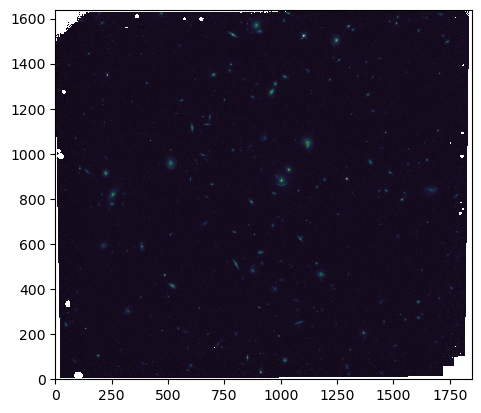

In [148]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [149]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

C:\Users\HTCM\AppData\Local\Temp\ipykernel_5424\1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


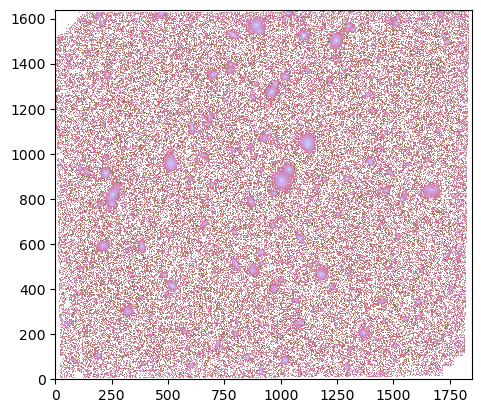

In [150]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [151]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.25551219532307734, 0.012066100362562024)

In [152]:
bkg_subtracted_data = data - bkg.background

In [153]:
threshold = 5 * bkg.background_rms

In [154]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [155]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [156]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (1640, 1849)
nlabels: 524
labels: [  1   2   3   4   5 ... 520 521 522 523 524]


In [157]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 524
labels: [  1   2   3   4   5 ... 520 521 522 523 524]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [158]:
set_x_lim1, set_x_lim2 = 500, 1500
set_y_lim1, set_y_lim2 = 600, 1350

C:\Users\HTCM\AppData\Local\Temp\ipykernel_5424\3753934783.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


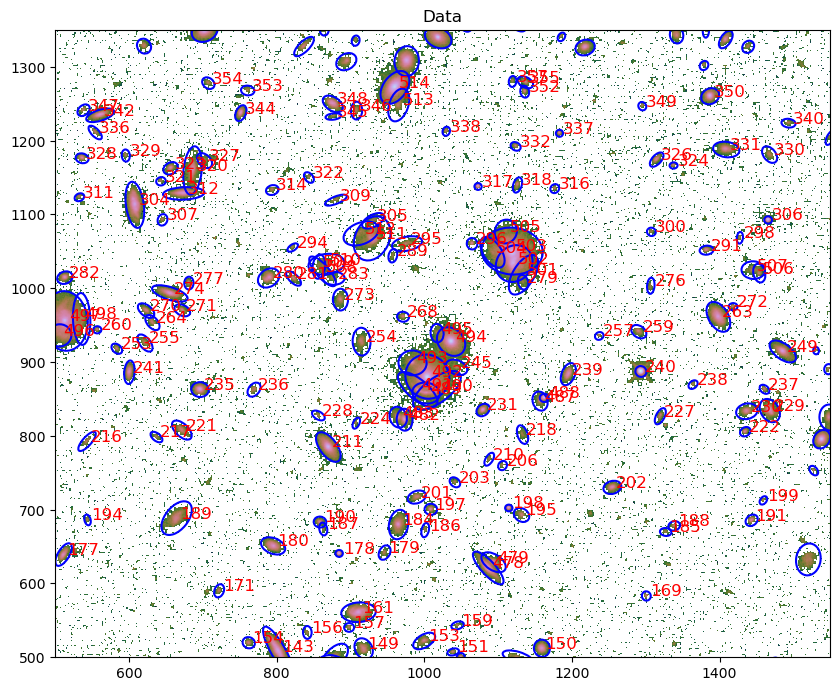

In [159]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)


for i in range(len(cat)):
    # cat.xcentroid[492]
    # cat.ycentroid[492]
    if np.abs(cat.xcentroid[i] - 1000) < 500 and np.abs(cat.ycentroid[i] - 900) < 400:
        ax1.text(
            cat.xcentroid[i] + 5,
            cat.ycentroid[i],
            f"{i}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(set_x_lim1, set_x_lim2 + 50)
ax1.set_ylim(set_y_lim1 - 100, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

C:\Users\HTCM\AppData\Local\Temp\ipykernel_5424\1334993166.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


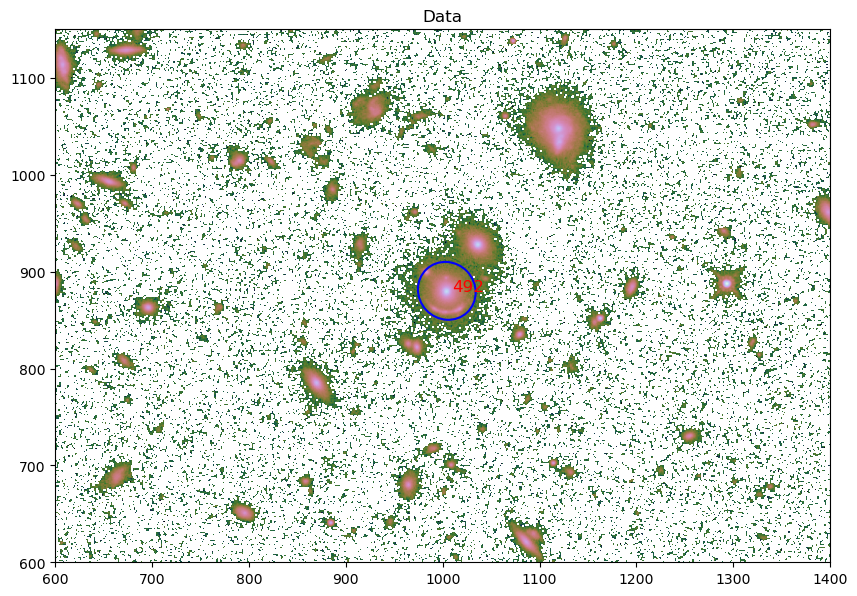

In [160]:
# object id of your central deflector/lens
id_central = 492

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

ax1.set_xlim(set_x_lim1 + 100, set_x_lim2 - 100)
ax1.set_ylim(set_y_lim1, set_y_lim2 - 200)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [161]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [162]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 20 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 20 arcsecond radius: 52


In [165]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 20 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 20 arcsecond radius: 42


In [166]:
def distance_arcsec(pixel_distance):
    """Convert distance from unit of pixels into arcsec unit.
    :param pixel_distance: distance in unit of pixels
    :return: distance in arcsec unit
    """
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [167]:
"""
Object with index 492 corresponds to our lens system, and
indices 489, 490, and 491 represent lensed arcs. On the other hand,
objects at indices 279, 501, and 504 are artefacts and
we intend to eliminate all of them from analysis.
"""

remove_list = [492, 490, 489, 279, 501, 504, 491]

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 10 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
493         27.452155         15.860252   59.250348    0.879772
245         41.513453         15.860252   14.979994    0.637094
494         57.396017         15.860252  367.096557    0.795915
495         60.368131         15.860252   11.653550    0.698637
482         65.959762         15.860252   51.045589    0.724552
483         67.638345         15.860252   28.429093    0.797171
268         87.611630         15.860252    6.884013    0.827438
231         87.890268         15.860252   31.715868    0.763029
254        100.986307         15.860252   22.246797    0.640860
224        115.084141         15.860252    2.678914    0.529612
210        139.786441         15.860252    3.236779    0.496465
203        147.888086         15.860252    3.117071    0.736577
218        150.957942         15.860252    6.830461    0.521050
487        156.251398         15.860252   16.429314    0.754942
228        156.744578         15.860252 

In [168]:
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list)

# first 10 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
493         27.452155         15.860252   59.250348    0.879772
245         41.513453         15.860252   14.979994    0.637094
494         57.396017         15.860252  367.096557    0.795915
495         60.368131         15.860252   11.653550    0.698637
482         65.959762         15.860252   51.045589    0.724552
483         67.638345         15.860252   28.429093    0.797171
268         87.611630         15.860252    6.884013    0.827438
231         87.890268         15.860252   31.715868    0.763029
254        100.986307         15.860252   22.246797    0.640860
218        150.957942         15.860252    6.830461    0.521050
487        156.251398         15.860252   16.429314    0.754942
273        157.381474         15.860252   17.925073    0.693093
488        160.956856         15.860252   48.383008    0.909309
201        163.786753         15.860252   14.706347    0.651256
211        164.601358         15.860252 

## Determining Sigma 10, 20 and R 10, 20

C:\Users\HTCM\AppData\Local\Temp\ipykernel_5424\2905231508.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\HTCM\AppData\Local\Temp\ipykernel_5424\2905231508.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\HTCM\AppData\Local\Temp\ipykernel_5424\2905231508.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\HTCM\AppData\Local\Temp\ipykernel_5424\2905231508.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: 15.860252482609672
R 20: 15.860252482609672
Sigma 10: 0.012654061300241866
Sigma 20: 0.02530812260048373

FOR All SOURCES
R 10: 15.860252482609672
R 20: 15.860252482609672
Sigma 10: 0.012654061300241866
Sigma 20: 0.02530812260048373


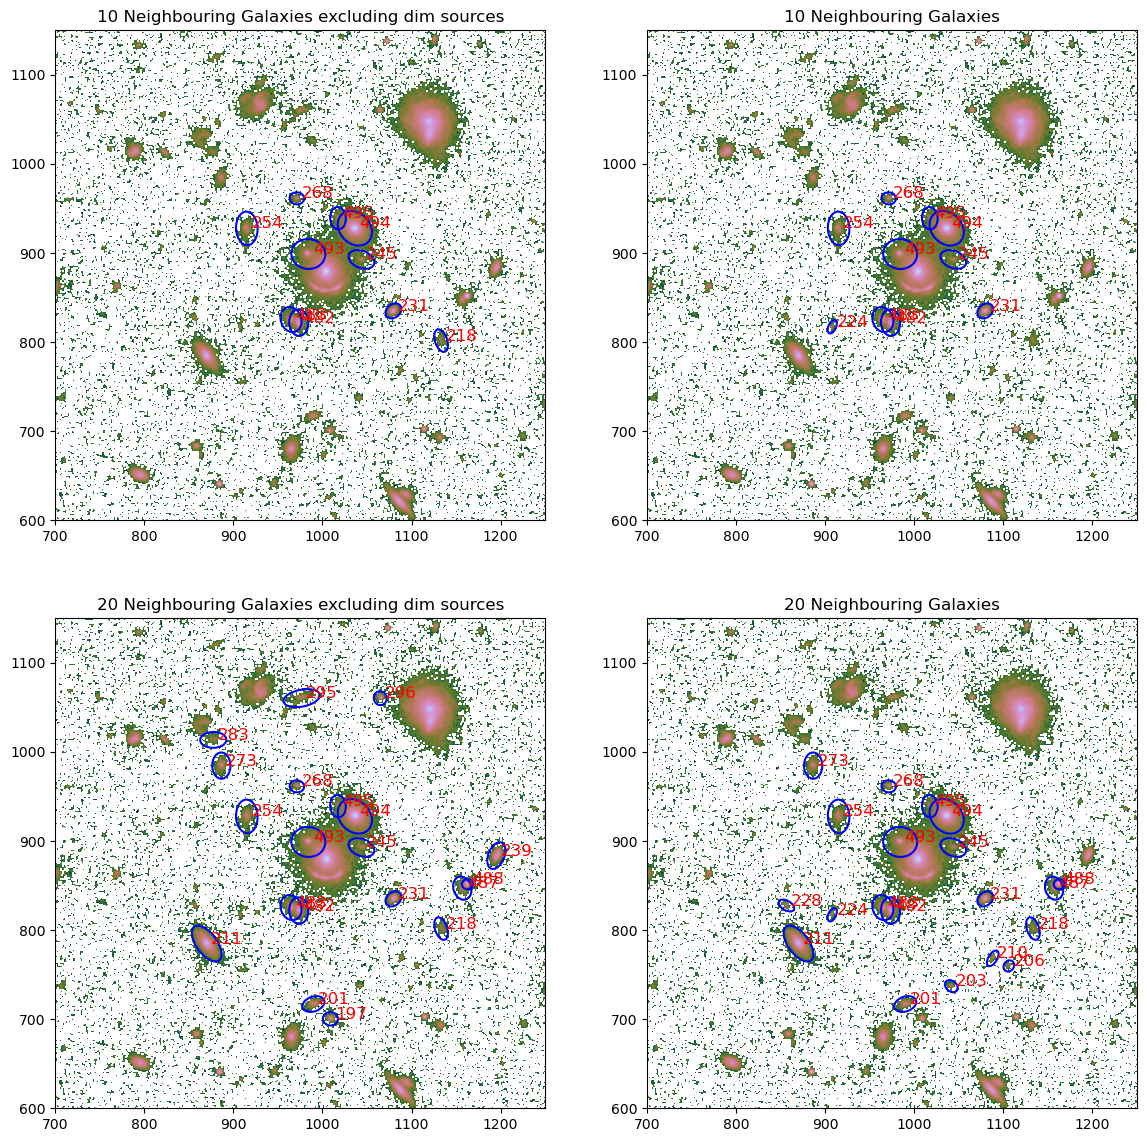

In [169]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1 + 200, set_x_lim2 - 250)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2 - 200)

axs[0, 1].set_xlim(set_x_lim1 + 200, set_x_lim2 - 250)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2 - 200)

axs[1, 0].set_xlim(set_x_lim1 + 200, set_x_lim2 - 250)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2 - 200)

axs[1, 1].set_xlim(set_x_lim1 + 200, set_x_lim2 - 250)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2 - 200)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

R_10_1 = df_1_20.iloc[
    9 - 1, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_1 = df_1_20.iloc[
    19 - 1, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[
    9 - 1, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_all = df_all_20.iloc[
    19 - 1, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

## Save the final deriverables to the YAML file

In [170]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1537+1443_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20_flux_selected": Sigma_20_1,
    "Sigma_10": Sigma_10_all,
    "Sigma_20": Sigma_20_all,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [171]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff': [0.7147395840168296, 0.003976647990712623, 0.004409238435153173], 'Sigma_10': 0.012654061300241866, 'Sigma_10_flux_selected': 0.012654061300241866, 'Sigma_20': 0.02530812260048373, 'Sigma_20_flux_selected': 0.02530812260048373, 'center_x_light': [-0.06781251377880426, 0.0006395967275077824, 0.0006484258640180596], 'center_x_mass': [-0.07318949617444911, 0.004833828416083916, 0.0054359481713791985], 'center_y_light': [-0.34257704679845125, 0.0006285376533772813, 0.0006334874514735134], 'center_y_mass': [0.15602440854776023, 0.03414937756886219, 0.03235488979065686], 'gamma': [2.1623734796583003, 0.04945105813986794, 0.0441443521986713], 'gamma_shear': [-0.11738541641751771, 0.18322845469496837, 0.24285420449977058], 'phi_light': [1.3415615165872163, 0.017267608609442764, 0.017388356699623575], 'phi_mass': [1.4191625976970073, 0.025588993660968784, 0.02681699888260436], 'phi_shear': [0.027002839229764174, 0.014649912686141117, 0.0139252291716471]